In [92]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt

In [93]:
df = pd.read_csv("/content/enhanced_data.csv")

In [94]:
df.head()

,user_id,department,privilege_level,session_id,timestamp,login_time,logout_time,session_minutes,device_type,location_country,...,time_risk,file_risk,geo_risk,app_risk,auth_risk,risk_score,alert_priority,anomaly_score,is_anomaly,anomaly_type
0,user_00028,HR,user,user_00028-2025-05-30-2-02e74388,30-05-2025 06:00,06:00:00,06:19:00,19,Mobile,India,...,10,15.41,0,0,0,25,Low,0.346,0,NaN
1,user_00003,R&D,user,user_00003-2025-05-30-0-070a3745,30-05-2025 06:07,06:07:00,07:49:00,102,Windows-PC,India,...,10,5.31,0,0,0,15,Low,0.277,0,NaN
2,user_00117,Sales,developer,user_00117-2025-05-30-0-94eb38ca,30-05-2025 06:13,06:13:00,06:39:00,26,Linux-Server,India,...,10,16.68,0,0,0,26,Low,0.316,0,NaN
3,user_00059,HR,user,user_00059-2025-05-30-1-255d9b1b,30-05-2025 06:20,06:20:00,08:26:00,126,Mobile,India,...,10,6.23,0,0,0,16,Low,0.326,0,NaN
4,user_00025,IT,user,user_00025-2025-05-30-0-51f7a24a,30-05-2025 06:21,06:21:00,06:41:00,20,Windows-PC,India,...,10,11.67,0,0,0,21,Low,0.275,0,NaN


In [95]:
df.columns

Index(['user_id', 'department', 'privilege_level', 'session_id', 'timestamp',
       'login_time', 'logout_time', 'session_minutes', 'device_type',
       'location_country', 'ip_address', 'remote_ip', 'remote_ip_type',
       'port_used', 'files_accessed', 'bytes_downloaded', 'direction',
       'app_used', 'file_sensitivity', 'sensitive_command', 'failed_logins',
       'mfa_used', 'time_risk', 'file_risk', 'geo_risk', 'app_risk',
       'auth_risk', 'risk_score', 'alert_priority', 'anomaly_score',
       'is_anomaly', 'anomaly_type'],
      dtype='object')

In [96]:
df.describe()

,session_minutes,port_used,files_accessed,bytes_downloaded,sensitive_command,failed_logins,time_risk,file_risk,geo_risk,app_risk,auth_risk,risk_score,anomaly_score,is_anomaly
count,39600.000000,39600.000000,39600.000000,39600.000000,39600.000000,39600.000000,39600.000000,39600.000000,39600.000000,39600.000000,39600.000000,39600.000000,39600.000000,39600.000000
mean,60.210581,887.991667,5.544343,239213.951768,0.010025,0.050303,0.670202,9.948609,0.764899,0.389394,0.416793,11.691995,0.216851,0.050000
std,60.045955,1102.314563,2.922633,153548.357616,0.099624,0.223259,2.500601,4.828575,2.657837,2.763412,1.487728,6.840936,0.090796,0.217948
min,5.000000,22.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000
25%,17.000000,80.000000,3.000000,115644.500000,0.000000,0.000000,0.000000,6.210000,0.000000,0.000000,0.000000,7.000000,0.151000,0.000000
50%,41.000000,443.000000,6.000000,223540.000000,0.000000,0.000000,0.000000,9.500000,0.000000,0.000000,0.000000,11.000000,0.207000,0.000000
75%,84.000000,1433.000000,8.000000,341350.250000,0.000000,0.000000,0.000000,13.140000,0.000000,0.000000,0.000000,15.000000,0.272000,0.000000
max,480.000000,3389.000000,19.000000,955470.000000,1.000000,2.000000,10.000000,32.660000,10.000000,20.000000,25.000000,59.000000,0.751000,1.000000


In [98]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import xgboost as xgb

#categorical features
df['mfa_used'] = df['mfa_used'].map({'No': 0, 'Yes': 1})
df['alert_priority'] = df['alert_priority'].map({'Low': 0, 'Medium': 1, 'High': 2})
if df['sensitive_command'].dtype == object:
    df['sensitive_command'] = df['sensitive_command'].map({'No': 0, 'Yes': 1})

#create encoded columns (save originals for plots)
label_encoders = {}
categorical_cols = ['privilege_level', 'device_type', 'direction', 'app_used', 'file_sensitivity', 'anomaly_type', 'location_country']
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  #encoders for possible reverse-transform

#for modeling
features = [
    'privilege_level_encoded', 'session_minutes', 'files_accessed', 'bytes_downloaded',
    'device_type_encoded', 'location_country_encoded', 'port_used', 'app_used_encoded',
    'file_sensitivity_encoded', 'sensitive_command', 'failed_logins', 'mfa_used', 'direction_encoded',
    'time_risk', 'file_risk', 'geo_risk', 'app_risk', 'auth_risk',
    'alert_priority', 'anomaly_score', 'anomaly_type_encoded'
]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
y = df['is_anomaly']

model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=50, use_label_encoder=False, eval_metric='logloss')
model.fit(X_scaled, y)

df['risk_score_xgb'] = model.predict_proba(X_scaled)[:, 1]

# top 10 Risky Sessions
df[['user_id', 'privilege_level', 'files_accessed', 'direction', 'bytes_downloaded',
        'app_used', 'risk_score_xgb', 'anomaly_type']].sort_values('risk_score_xgb', ascending=False).head(10)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:44:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,user_id,privilege_level,files_accessed,direction,bytes_downloaded,app_used,risk_score_xgb,anomaly_type
409,user_00103,user,11,Download,37158,excel,0.999381,exfiltration_external
31024,user_00107,user,6,Download,132740,excel,0.999381,failed_logins
34972,user_00114,user,11,Internal,55708,file_explorer,0.999379,failed_logins
2107,user_00005,developer,8,Download,134441,excel,0.999379,account_sharing
24973,user_00070,user,9,Internal,144785,excel,0.999379,mass_download
28216,user_00110,user,13,Download,215182,excel,0.999378,exfiltration_external
9723,user_00046,user,9,Download,94849,excel,0.999378,bot_activity
12994,user_00059,user,9,Upload,75734,excel,0.999378,file_sensitivity_violation
18025,user_00110,user,6,Download,88391,excel,0.999378,geo_impossible
31201,user_00029,user,11,Internal,69695,excel,0.999378,geo_impossible


In [84]:
#high risk as top 10% risk_score_xgb
risk_thresh = df['risk_score_xgb'].quantile(0.9)
df['is_high_risk'] = (df['risk_score_xgb'] >= risk_thresh).astype(int)

#aggregation of app usage by all users and risky users
app_usage = df.groupby('app_used').agg(total_uses=('user_id', 'count'), high_risk_uses=('is_high_risk', 'sum')).reset_index()

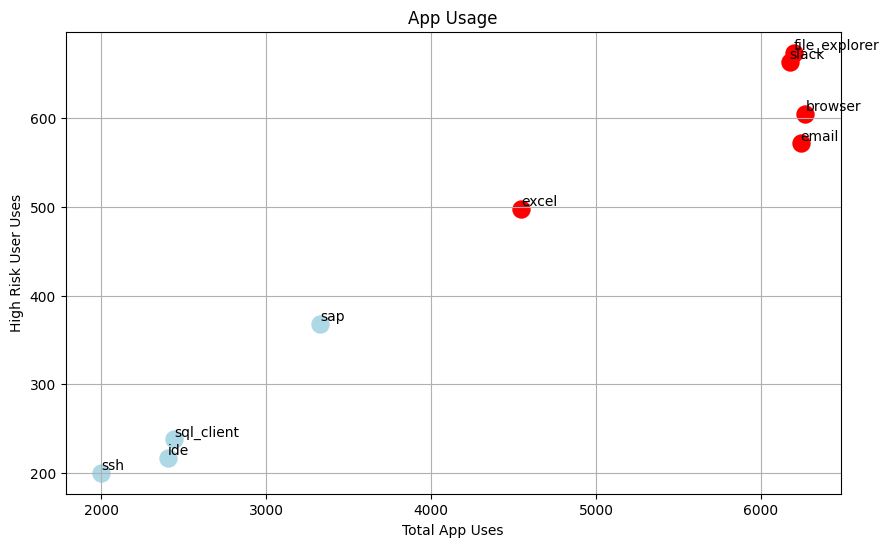

In [85]:
#scaling
scaler_apps = MinMaxScaler()
metrics_scaled = scaler_apps.fit_transform(app_usage[['total_uses', 'high_risk_uses']])

#clustering
kmeans = KMeans(n_clusters=2, random_state=42).fit(metrics_scaled)
app_usage['cluster'] = kmeans.labels_

#highest avg high-risk-users
red_cluster = app_usage.groupby('cluster')['high_risk_uses'].mean().idxmax()

plt.figure(figsize=(10, 6))
for i, row in app_usage.iterrows():
    color = 'red' if row['cluster'] == red_cluster else 'lightblue'
    plt.scatter(row['total_uses'], row['high_risk_uses'], s=150, color=color)
    plt.text(row['total_uses'], row['high_risk_uses'], row['app_used'], fontsize=10, ha='left', va='bottom')

plt.xlabel('Total App Uses')
plt.ylabel('High Risk User Uses')
plt.title('App Usage')
plt.grid(True)
plt.show()

/tmp/ipython-input-2117648234.py:10: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  timeline_df['timestamp'] = pd.to_datetime(timeline_df['timestamp'])


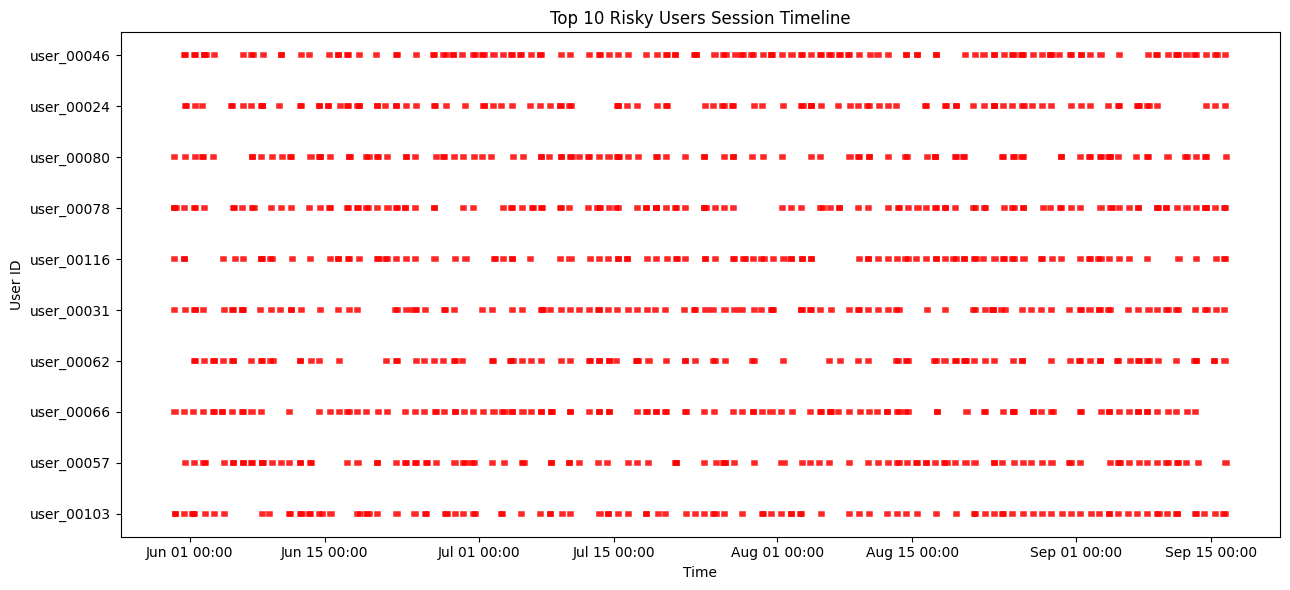

In [86]:
import matplotlib.dates as mdates

#top 10 risky users by average risk score
user_avg_risk = df.groupby('user_id')['risk_score_xgb'].mean().sort_values(ascending=False)
top_users = user_avg_risk.head(10).index.tolist()
#top users sessions filtering
timeline_df = df[df['user_id'].isin(top_users)].copy()

#timestamp with login_time and logout_time for session start/end datetimes
timeline_df['timestamp'] = pd.to_datetime(timeline_df['timestamp'])
timeline_df['login_time'] = pd.to_datetime(timeline_df['login_time'], format='%H:%M:%S').dt.time
timeline_df['logout_time'] = pd.to_datetime(timeline_df['logout_time'], format='%H:%M:%S').dt.time

timeline_df['session_start'] = timeline_df.apply(
    lambda row: pd.Timestamp.combine(row['timestamp'].date(), row['login_time']), axis=1)
timeline_df['session_end'] = timeline_df.apply(
    lambda row: pd.Timestamp.combine(row['timestamp'].date(), row['logout_time']), axis=1)

#plotting positions
user_to_y = {user: i for i, user in enumerate(top_users)}
timeline_df['user_y'] = timeline_df['user_id'].map(user_to_y)

fig, ax = plt.subplots(figsize=(13, 6))
for _, row in timeline_df.iterrows():
    ax.plot([row['session_start'], row['session_end']], [row['user_y'], row['user_y']], color='red', linewidth=4, alpha=0.85)
ax.set_yticks(list(user_to_y.values()))
ax.set_yticklabels(list(user_to_y.keys()))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
plt.title('Top 10 Risky Users Session Timeline')
plt.xlabel('Time')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()

In [87]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
#label columns removed

unsupervised_features = [
    'privilege_level_encoded', 'session_minutes', 'files_accessed', 'bytes_downloaded',
    'device_type_encoded', 'location_country_encoded', 'port_used', 'app_used_encoded',
    'file_sensitivity_encoded', 'sensitive_command', 'failed_logins', 'mfa_used', 'direction_encoded',
    'time_risk', 'file_risk', 'geo_risk', 'app_risk', 'auth_risk',
    'alert_priority', 'anomaly_score']

# Scale features for robust performance
scaler = MinMaxScaler()
X_unsup = scaler.fit_transform(df[unsupervised_features])

# Fit Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df['iso_outlier_label'] = iso_forest.fit_predict(X_unsup)    # -1 = outlier/anomaly, 1 = normal
df['iso_anomaly_score'] = -iso_forest.decision_function(X_unsup)  # Higher = more anomalous

# Show the most anomalous sessions/users
outliers = df[df['iso_outlier_label'] == -1]
outliers[['user_id', 'risk_score_xgb', 'iso_anomaly_score', 'app_used', 'session_minutes', 'files_accessed']].sort_values('iso_anomaly_score', ascending=False).head(10)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


,user_id,risk_score_xgb,iso_anomaly_score,app_used,session_minutes,files_accessed
20176,user_00030,0.000048,0.127205,ssh,18,10
721,user_00050,0.000050,0.122814,sql_client,399,9
23756,user_00095,0.000048,0.121399,ssh,154,6
25741,user_00041,0.000048,0.112218,ssh,5,1
26410,user_00051,0.000048,0.108951,slack,94,10
32082,user_00016,0.000047,0.107112,sql_client,50,0
23094,user_00064,0.000048,0.106323,sql_client,214,3
24078,user_00069,0.000048,0.104048,ssh,67,12
22537,user_00013,0.000048,0.103299,sql_client,69,11
20341,user_00044,0.000047,0.103264,ide,5,11


In [88]:
print(f"\nTotal anomalies detected by Isolation Forest: {sum(df['iso_outlier_label'] == -1)} out of {len(df)}")


Total anomalies detected by Isolation Forest: 3960 out of 39600


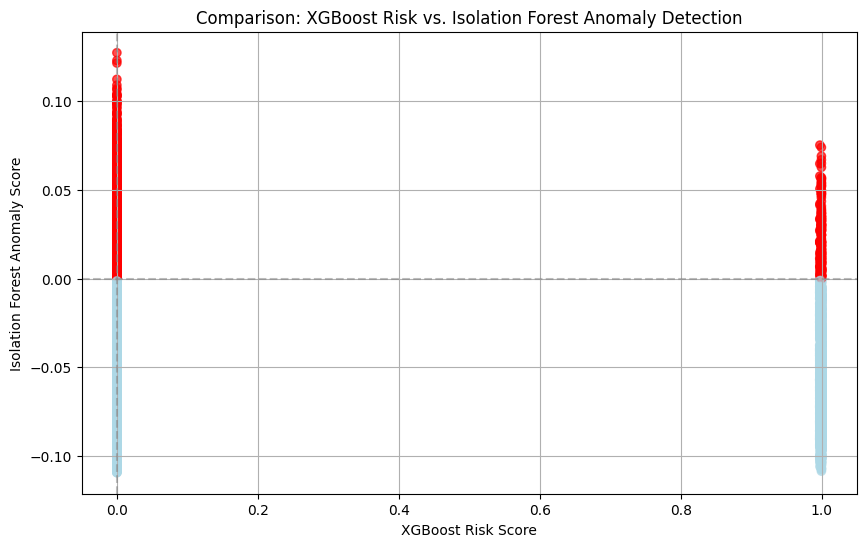

Sessions flagged as risky by both XGBoost (top 10%) and IF (red): 263


In [89]:
import matplotlib.pyplot as plt

# Assume df has:
#risk_score_xgb (continuous: 0-1)
#iso_anomaly_score (continuous: higher = more anomalous)
#iso_outlier_label (-1 / 1 from Isolation Forest)

plt.figure(figsize=(10, 6))
plt.scatter(
    df['risk_score_xgb'],
    df['iso_anomaly_score'],
    c=['red' if label == -1 else 'lightblue' for label in df['iso_outlier_label']],
    alpha=0.7,
    label='Sessions'
)
plt.xlabel('XGBoost Risk Score')
plt.ylabel('Isolation Forest Anomaly Score')
plt.title('Comparison: XGBoost Risk vs. Isolation Forest Anomaly Detection')
plt.grid(True)
#plt.legend(['IF-flagged Outliers (red)', 'Normal (blue)'], loc='best')

# Optional: threshold lines for quick quadrants
plt.axvline(df['risk_score_xgb'].quantile(0.9), color='grey', linestyle='--', alpha=0.5)
plt.axhline(df['iso_anomaly_score'].quantile(0.9), color='grey', linestyle='--', alpha=0.5)
plt.show()

print("Sessions flagged as risky by both XGBoost (top 10%) and IF (red):", sum((df['risk_score_xgb'] >= df['risk_score_xgb'].quantile(0.9)) & (df['iso_outlier_label'] == -1)))